Для любых пар изображений которые имеют общее поле зрения (две фотографии сделанные с телефона который был повернут на определенный угол - любой лишь бы было 20+% перекрытия)
Рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

In [104]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [137]:
def extract_features(image, detector='sift', mask=None):

    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [138]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [139]:
def filter_matches_distance(matches, dist_threshold):
    
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

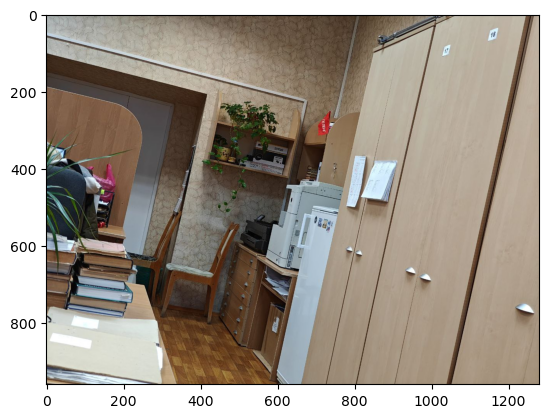

In [140]:
# Загружаем наши изображения
input_img0 = cv2.imread("photo_1.jpg")
img0 = cv2.cvtColor(input_img0,cv2.COLOR_BGR2RGB)
input_img1 = cv2.imread("photo_2.jpg")
img1 = cv2.cvtColor(input_img1,cv2.COLOR_BGR2RGB)
plt.imshow(img0)

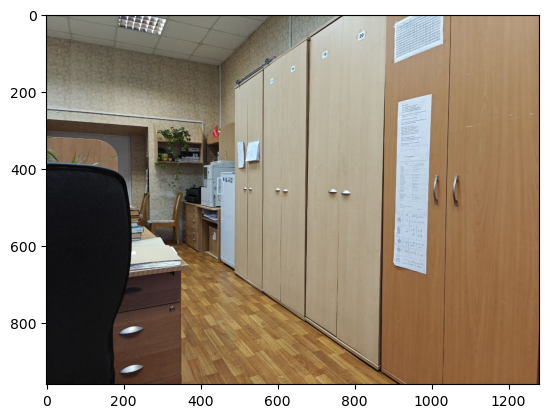

In [141]:
plt.imshow(img1)

In [142]:
# Добавляем размытие 
blurred = cv2.GaussianBlur(img0, (11,11),0)
img0 = cv2.addWeighted(img0, 2, blurred, -1, 0)    
blurred = cv2.GaussianBlur(img1, (11,11),0)
img1 = cv2.addWeighted(img1, 2, blurred, -1, 0)

In [143]:
# Отобразить точки
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    # Убираем оси
    plt.axis('off')

    # Сохраняем график в файл
    plt.savefig('plot_without_axes.png', bbox_inches='tight', pad_inches=0)

Number of matches before filtering: 3005
Number of matches after filtering: 95


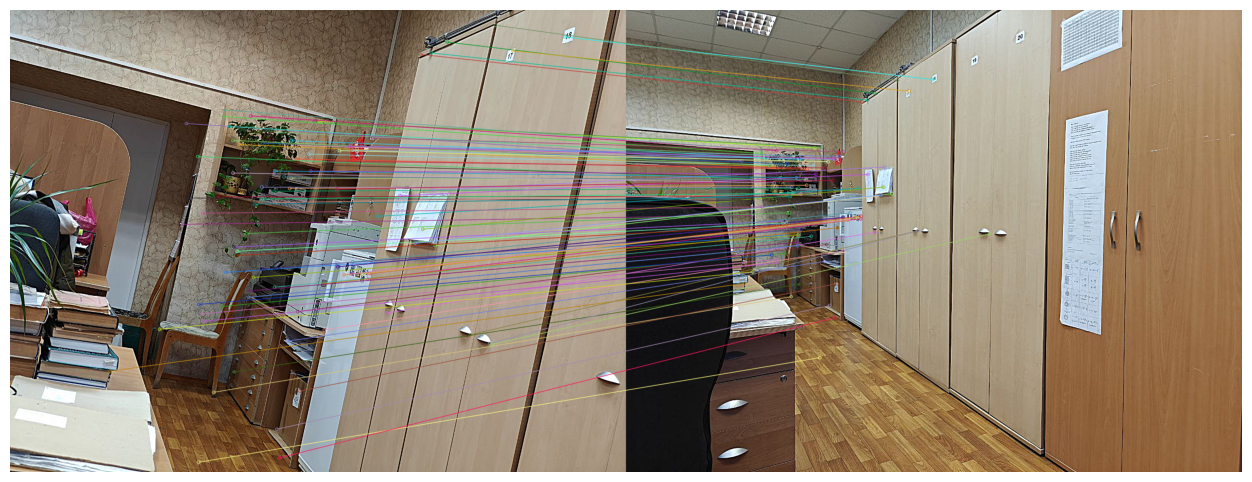

In [144]:
kp0, des0 = extract_features(img0, 'sift')
kp1, des1 = extract_features(img1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.5)
print('Number of matches after filtering:', len(matches))
visualize_matches(img0, kp0, img1, kp1, matches)

In [145]:
src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

In [147]:
def estimate_partial_transform(cur_matched_kp, prev_matched_kp ,method):
    
    transform = cv2.estimateAffine2D(np.array(prev_matched_kp),
                                           np.array(cur_matched_kp),method=method)[0] 
                                                                                         
    #print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    return [dx, dy, da], transform

In [148]:
m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)
m

[84.85332046468427, -468.9622746274091, 0.23623823253601092]

In [149]:
M

array([[ 1.74040659e+00, -4.32508977e-01,  8.48533205e+01],
       [ 4.18973831e-01,  1.88481573e+00, -4.68962275e+02]])

In [150]:
# Матрица афинного преобразования
afine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)
afine_transform_matrix

array([[ 1.74040659e+00, -4.32508977e-01,  8.48533205e+01],
       [ 4.18973831e-01,  1.88481573e+00, -4.68962275e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [152]:
def decompose_affine_matrix(affine):

    if affine.shape != (3, 3) or affine.dtype != np.float64:
        raise ValueError("Invalid input matrix. Must be a 3x3 double matrix.")

    R = affine[:2, :2]
    U, W, Vt = np.linalg.svd(R)

    rotation = np.dot(U, Vt)
    scaling = np.diag(W)
    translation = affine[:2, 2:]

    return rotation, translation, scaling

In [153]:
rotation, translation, scaling = decompose_affine_matrix(np.linalg.inv(afine_transform_matrix))
print(f"rotation = {rotation}, translation = {translation}, scaling = {scaling}")

rotation = [[ 0.97350754  0.22865492]
 [-0.22865492  0.97350754]], translation = [[ 12.39255549]
 [246.05594653]], scaling = [[0.55884109 0.        ]
 [0.         0.51694025]]


In [154]:
def get_angle(rotation):
    return np.arctan2(rotation[1, 0], rotation[0, 0])
def get_scale(scaling):
    return np.sqrt(scaling[0, 0] ** 2 + scaling[1, 1] ** 2)
def get_translation(translation):
    return translation
def get_angle_degrees(rotation):
    return np.degrees(np.arctan2(rotation[1, 0], rotation[0, 0]))

In [155]:
angle = get_angle_degrees(rotation)
scale = get_scale(scaling)
translation = get_translation(translation)

print("Угол:", angle)
print("Коэффициент увеличения:", scale)
print("Перевод:", translation)

Угол: -13.217894399774647
Коэффициент увеличения: 0.7612690633893393
Перевод: [[ 12.39255549]
 [246.05594653]]


In [156]:
def recompose_affine_matrix(rotation, translation, scaling):
    
    # Combine rotation and scaling
    rotation_scaling = np.dot(rotation, scaling)
    
    # Create the 3x3 affine matrix
    affine = np.eye(3)
    affine[:2, :2] = rotation_scaling
    affine[:2, 2] = translation.flatten()
    
    return affine

In [157]:
recomposed_affine = recompose_affine_matrix(rotation, translation, scaling )
recomposed_affine

array([[ 5.44036010e-01,  1.18200934e-01,  1.23925555e+01],
       [-1.27781766e-01,  5.03245235e-01,  2.46055947e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

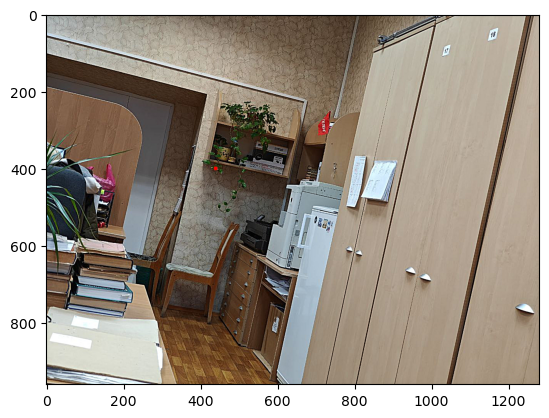

In [158]:
original_image = cv2.circle(img0.copy(), (int(440),int(400)), 5, (255, 0, 0), -1)
plt.imshow(original_image)

In [159]:
afine_transform_matrix=recomposed_affine.copy()

In [160]:
x_hom = np.array([440,400, 1])
x_hom_new = np.dot(afine_transform_matrix, x_hom)
x_new = x_hom_new[0]
y_new = x_hom_new[1]

In [161]:
[x_new, y_new]

[299.048773625042, 391.13006343222]

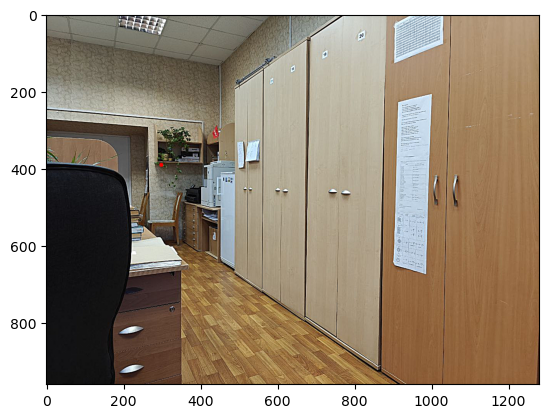

In [162]:
new_image = cv2.circle(img1.copy(), (int(x_new), int(y_new)), 5, (255, 0, 0), -1)
plt.imshow(new_image)

In [163]:
rotation, translation, scaling = decompose_affine_matrix(np.linalg.inv(afine_transform_matrix))

In [164]:
angle = get_angle_degrees(rotation)
scale = get_scale(scaling)
translation = get_translation(translation)

print("Угол:", angle)
print("Коэффициент увеличения:", scale)
print("Перевод:", translation)

Угол: 13.217894399774647
Коэффициент увеличения: 2.6351752349017046
Перевод: [[  79.08806011]
 [-468.85676867]]


#Вывод
Рассчитали матрицу афинного преобразования из одной системы координат в другую для двух изображения. Выполнили разложение данной матрицы и посчитали явно угол поворота, вектор переноса и скалирования. 
Выполнили обратное преобразование - получили афинную матрицу заново. Расзложили ее и получили обратные угол, вектор и скалирование.